# Multiple Linear Regression using `tensorflow`

Just as with `theano`, we'll use `tensorflow` to build up a computational graph and take advantage of it's automatic differentiation to learn the coefficients for our multiple linear regression problem. 

## Computational Graphs for Multiple Linear Regression 

Let's keep the computational graph visuals around for reference: 

### Forward Propagation

<img src="../imgs/custom/mult_linear_comp_graph_condensed_forprop.png" width=300\>

### Backward Propagation

<img src="../imgs/custom/mult_linear_comp_graph_condensed_backprop.png" width=400\>

### Building a computational graph with `tensorflow`

The biggest difference between the `numpy` implementation and the `tensorflow` implementation of our multiple linear regression problem is that we'll be able to use the automatic differentiation that `tensorflow` offers. In comparing `theano` to `tensorflow`, we'll see similar syntax when building up the graph, but different syntax when actually performing the iterations of gradient descent. Let's take a look...

In [1]:
import numpy as np
import tensorflow as tf
from datasets.general import gen_multiple_linear
from utils.plotting import plot_errors
%matplotlib inline

In [2]:
def get_tensorflow_graph(): 
    learning_rate = 0.1
    # 1. Define placeholder matrices for inputs.
    xs = tf.placeholder(tf.float64, name='xs') 
    ys = tf.placeholder(tf.float64, name='ys')
    # 2. Define randomly initialized floats for our betas. 
    betas = tf.Variable(np.random.random(size=(4, 1)), name='betas')

    # 3. Define the equation that generates predictions.
    yhats = tf.matmul(xs, betas)
    # 4. Define the equation that generates our errors. 
    es = 0.5 * (ys - yhats) ** 2
    # 5. Define the aggregate cost (mean of squared errors)
    E = tf.reduce_mean(es)
    # 6. Take advantage of `tensorflows` optimizer to automate differentiation
    #    as well as the update step. 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(E)
    
    return E, betas, train, xs, ys

Our multiple linear regression solution with `tensorflow` is going to differ from our `theano` solution (notebook `2c`) in the same way it did for simple linear regression -  `get_tensorflow_graph` will return back the steps necessary to perform forward and backward propagation as multiple pieces, rather than one callable function. Steps `1-5` will still correspond to the forward pass and step `6` the backward pass. Compared to our `tensorflow` implementation for simple linear regression, we see a slight difference in step `6`, which we'll walk through below. 

In terms of the individual pieces being returned: 

1. The mean squared error (`E`) is returned so that we can track it through each iteration. 
2. `betas` are returned so that we can reference them below to initialize them (see the `tf.intialize_variables` call; we could also use `tf.initialize_all_variables`). Note the generation of `betas` as a [Variable object](https://www.tensorflow.org/versions/r0.9/get_started/basic_usage.html#variables) - this is what allows our coefficient values to be updated and shared across iterations. 
3. `train` holds the magic of our computational graph, and is different from how we solved simple linear regression with `tensorflow`. With simple linear regression, we were explicit about our backward propagation steps, and coded up each individual equation for updating our coefficients. Here, we instead feed the quantity that we want minimized (the **mean squared error**, `E`) to a [tensorflow Optimizer](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html), which provides us with a simple interface for performing gradient descent. 

 When we call [minimize](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html#processing-gradients-before-applying-them) on this `Optimizer`, it builds the calculation of the derivatives and the performing of the updates into our computational graph. It by default takes the derivatives of all of the `tf.Variable` objects that it finds in the computational graph prior to that step. Here, this is just `betas`. 
 
 When `train` is run in a session below, any steps that are necessary to perform the minimization step will be run, which in effect is every step that is part of the forward and backward propagation.
4. Finally, `xs` and `ys` are placeholders for our data, and are returned so that we can tell `tensorflow` exactly what part of our graph the real data should line up with. 

Next, we'll use one of the `Session` objects we've discussed to perform gradient descent and learn the true values for each beta coefficient in `betas`. 

Final Error: 7.27221469624278e-22


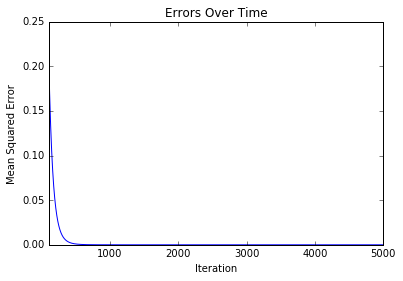

In [3]:
# Randomly generate our betas and number of observations, used to generate 
# fake data to fit. We should have a minimum of 4 obs, since we have 
# four coefficients. 
true_betas_array = np.random.randint(2, 10, size=4)
n_obs = np.random.randint(9000, 11000) 

# Generate the tensorflow graph. This is in a function so that we can run this cell multiple 
# times and obtain different randomly generated values for `beta_0` and `beta_1`. 
E, betas, train, xs, ys = get_tensorflow_graph()

# Generate the data that follows a linear relationship specified by `true_betas_array`.
x, y = gen_multiple_linear(true_betas_array, n_obs)

# Define the initialization operation. 
init = tf.initialize_variables([betas])
with tf.Session() as sess: 
    sess.run(init) # Perform the actual initialization operation. 

    # Perform iterations (forward & backward prop.) over the tensorflow graph
    mean_squared_errors = []
    for step in range(5000):
        mean_squared_error, _ = sess.run([E, train], feed_dict={xs : x, ys : y}) 
        mean_squared_errors.append(mean_squared_error)
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(mean_squared_errors, iterations=(100, 5000))
print("Final Error: {}".format(mean_squared_errors[-1]))

Just as with our simple linear regression implementation, we'll run gradient descent for our multiple linear regression problem via a `Session` object. This [Session object](https://www.tensorflow.org/versions/r0.9/api_docs/python/client.html#session-management) allows us to encapsulate all of the calculations and implementation details of our graph (or any graph) into a single environment. When running multiple graphs, each of which might have their own specialized environment, this is incredibly helpful. 

After initializing a `Session` object, our first step is to [initialize any variables](https://www.tensorflow.org/versions/r0.9/how_tos/variables/index.html#initialization) that are going to be used in the graph. Here, this is just the `betas` variable. Once we have created a `Session` object and initialized all of our variables, we can run parts of our graph or ask for values of variables by passing them into `Session.run`. Any time that we want to view the values held in the `betas` variable, for example, we run:  

```
Session.run(betas)
``` 

If we run this **before** any iterations of gradient descent have been performed, we'll be given back the initial values given to each of the coefficients in `betas`. In order to run one iteration of the gradient descent procedure, we pass `train` into `Session.run`: 

```
Session.run(train, feed_dict={xs : x, ys : y})
```


When this piece (or any piece) of the computational graph is passed into `Session.run`, any steps necessary to compute what is asked for will be run (for any `tf.Variable` the value is simply returned). For `train`, this is every step of the computational graph - the forward propagation (steps `1-5`) and the backward propagation / update (step `6`). To perform these steps, `xs` and `ys` are necessary, and are passed in via the `feed_dict` argument. The keys of the `feed_dict` are the variable names referring to the placeholder objects in the graph, and the values are the data that will be used for those placeholders. After running `train`, the `betas` will no longer correspond to their original values. Note that above we also ask for `E` back, which is what allows us to track our mean squared error through each iteration. 

Finally, if we run `train` through `Session.run` in a loop (as we do), we see that we can solve our multiple linear regression using this graph built in `tensorflow` and obtain the coefficient values that we expect.  

Now, we'll move on to coding this up with `keras`. 